In [1]:
from PIL import Image
import numpy as np
import cv2
import fnmatch
import os
import dlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Step 1 - crop heads of all images from students & faculties folder

In [2]:
def filelist(root):
    """Return a fully-qualified list of filenames under root directory"""
    filepath = []
    filename = []
    pattern = '*.jpg'
    for path, subdirs, files in os.walk(root):
        for name in fnmatch.filter(files, pattern):
            filepath.append(os.path.join(path, name))
            filename.append(name)
    return filepath, filename

In [43]:
student_folder = 'www.usfca.edu/sites/default/files/images/headshots/'
faculty_folder = 'www.usfca.edu/sites/default/files/styles/student_profile_500x500/public/images/headshots/'

student_files, s_filename = filelist(student_folder)
faculty_files, f_filename = filelist(faculty_folder)

In [97]:
len(student_files), len(faculty_files)

(76, 15)

In [5]:
# each image will display one second
for i in range(4):
    student_image = cv2.imread(student_files[i])
    cv2.imshow("Original", student_image)
    cv2.waitKey(1000)
    cv2.destroyAllWindows()

In [6]:
for i in range(4):
    student_image = cv2.imread(faculty_files[i])
    cv2.imshow("Original", student_image)
    cv2.waitKey(1000)
    cv2.destroyAllWindows()

### Step 2 - read the cropped faces

In [5]:
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

def aligned_image(filepath,filename):
    img = cv2.imread(filepath)
    dets = detector(img, 2)
    faces = dlib.full_object_detections()
    for detection in dets:
        faces.append(sp(img,detection))
    images = dlib.get_face_chips(img, faces, size=320, padding=0.35)
    for image in images:
        cv2.imwrite(filename, image)

Write new aligned images to images folders

In [6]:
for i in range(76):
    aligned_image(student_files[i], 'images/students/'+ s_filename[i])
    
for i in range(15):
    aligned_image(faculty_files[i], 'images/faculties/'+ f_filename[i])

Display 4 students aligned faces and then 4 faculty faces, each one second

In [3]:
student_folder = 'images/students/'
faculty_folder = 'images/faculties/'

s_aligned,_ = filelist(student_folder)
f_aligned,_ = filelist(faculty_folder)

In [9]:
for i in range(4):
    student_image = cv2.imread(s_aligned[i])
    cv2.imshow("Aligned", student_image)
    cv2.waitKey(1000)
    cv2.destroyAllWindows()

In [107]:
for i in range(4):
    faculty_image = cv2.imread(f_aligned[i])
    cv2.imshow("Aligend", faculty_image)
    cv2.waitKey(1000)
    cv2.destroyAllWindows()

###  Step 3 - construct a matrix where each column represents an image for students

In [4]:
s_aligned[45]

'images/students/msan-student-li-qian.jpg'

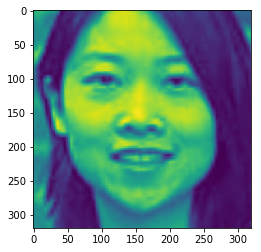

In [5]:
me_im = cv2.imread(s_aligned[45], 0)
plt.imshow(me_im)

In [6]:
# construct an empty matrix to store image vectors. This matrix has 76 dimensions and 65536 samples
sz = me_im.shape
num_student = len(s_aligned)
student_matrix = np.zeros((sz[0] * sz[1], num_student), dtype=np.float32)
student_matrix.shape 

(102400, 76)

In [7]:
# read images to matrix
for i in range(num_student):
    im = cv2.imread(s_aligned[i], 0).astype('uint8')
    im = im.flatten()
    student_matrix[:, i] = im

means = np.mean(student_matrix, axis=1) # average face
student_matrix -= means.reshape(-1,1)

### Step 4 - Use PCA to reduce dimension to 4 and draw the four eigenfaces

In [181]:
from sklearn.decomposition import PCA

In [182]:
pca = PCA(n_components=4)
student_matrix_new = pca.fit_transform(student_matrix) # same thing as: student_matrix.dot(pca.components_.T)
student_matrix_new.shape # 76 dimension is reduced to 4

(102400, 4)

In [83]:
## Another method using cv2
# mean, eigenVectors = cv2.PCACompute(student_matrix, mean=None, maxComponents=4)
# plt.imshow( (student_matrix.dot(eigenVectors.T)[:,i] + means).reshape(sz))

In [113]:
Eigenfaces = []
for i in range(4):
    # reshape each sample back to image format
    Eigenfaces.append(student_matrix_new[:,i].reshape(sz))

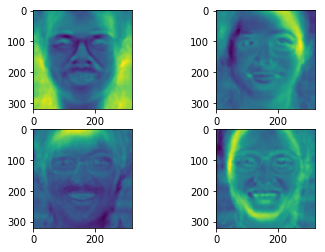

In [124]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(Eigenfaces[0])
axarr[0,1].imshow(Eigenfaces[1])
axarr[1,0].imshow(Eigenfaces[2])
axarr[1,1].imshow(Eigenfaces[3])
plt.show()

In [183]:
print(pca.explained_variance_ratio_.sum())  

0.461506372869


As the result is shown above, 46.2% of variability does these four faces make up for student group.

### Repeat step 3 and 4 for faculties

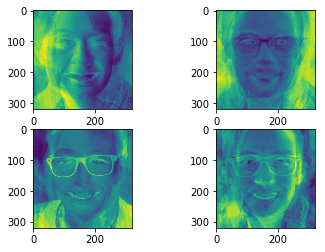

In [15]:
num_faculty = len(f_aligned)
faculty_matrix = np.zeros((sz[0] * sz[1], num_faculty), dtype=np.float32)

# read images to matrix
for i in range(num_faculty):
    im = cv2.imread(f_aligned[i], 0).astype('uint8')
    im = im.flatten()
    faculty_matrix[:, i] = im
    
# subtract mean from each column vector
fmeans = np.mean(faculty_matrix, axis=1)
faculty_matrix -= fmeans.reshape(-1,1)

pca2 = PCA(n_components=4)
faculty_matrix_new = pca2.fit_transform(faculty_matrix)

Eigenfaces2 = []
for i in range(4):
    Eigenfaces2.append(faculty_matrix_new[:,i].reshape(sz))
    
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(Eigenfaces2[0])
axarr[0,1].imshow(Eigenfaces2[1])
axarr[1,0].imshow(Eigenfaces2[2])
axarr[1,1].imshow(Eigenfaces2[3])
plt.show()

In [184]:
print(pca2.explained_variance_ratio_.sum())  

0.72147141455


As the result is shown above, 72.1% of variability does these four faces make up for faculty group.

### Step 5 - reconstruct the faces

In [117]:
pca.components_[:, 45] 

array([-0.1994929 , -0.17336668,  0.01436421, -0.08429943], dtype=float32)

Then my face is a linear combination of the eigenfaces with coefficeints: -0.1994929, -0.17336668, 0.01436421 and -0.08429943. The predicted face is drawn below

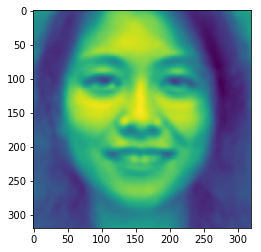

In [115]:
# student_matrix_new is of dim (102400, 4) and are 4 eigenfaces
plt.imshow((student_matrix_new.dot(pca.components_[:, 45]) + means).reshape(sz))

#### reconstruct second face

In [107]:
f_aligned[10]

'images/faculties/wilson-james.jpg'

In [120]:
pca2.components_[:, 10]

array([-0.13698739,  0.1403589 ,  0.21802011,  0.25065404], dtype=float32)

Jame's face is a linear combination of the eigenfaces with coefficeints: -0.13698739, 0.1403589,  0.21802011 and 0.25065404. The predicted face is drawn below.

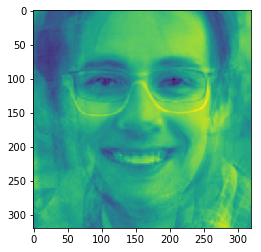

In [119]:
plt.imshow((faculty_matrix_new.dot(pca2.components_[:, 10])+ fmeans).reshape(sz))

### Step 6 - calculate similarity score between two group (student vs faculty)

I would measure similarity using cosine similarity

In [10]:
from scipy.spatial.distance import cosine

Similarity between two groups. I will sum up all pairwise similarities between students and faculties and divide by 76*15

In [19]:
cosine_similarity_matrix = np.zeros((76, 15), dtype=np.float32)

for i in range(75):
    for j in range(15):
        cosine_similarity_matrix[i,j] =1 - cosine(student_matrix[:,i], faculty_matrix[:,j])

In [21]:
cosine_similarity_matrix.sum()/(76*15)

0.0016095052685653954

By my metric, the similarity score between faculty and student groups is 0.0016, which is low.

### Step 7 - for all staff and students, construct similarity matrix and draw a plot to find who looks similar to who

In [148]:
# construct similarity matrix
cosine_similarity_matrix = np.zeros((91, 91), dtype=np.float32)
all_matrix = np.hstack((student_matrix, faculty_matrix))

for i in range(91):
    for j in range(91):
        if i==j:
            cosine_similarity_matrix[i,j] = 0
        else:
            cosine_similarity_matrix[i,j] =1 - cosine(all_matrix[:,i], all_matrix[:,j])

In [2]:
# get people's name from file
name_dict = {}
for i in range(76):
    name_dict[str(i)] = ' '.join(s_filename[i].split('.')[0].split('-')[-2:])
for i in range(76, 91):
    name_dict[str(i)] = ' '.join(f_filename[i-76].split('.')[0].split('-'))

In [29]:
import networkx as nx

In [160]:
# the function is to draw the network with name as labels.
# Only pairs with similarity score bigger than 0.68 is shown
def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix > 0.68)
    rows = [name_dict[str(i)] for i in rows]
    cols = [name_dict[str(i)] for i in cols]
    edges = zip(rows, cols)
    gr = nx.Graph()
    gr.add_edges_from(edges)
    pos = nx.spring_layout(gr)
    nx.draw(gr, node_size=300, with_labels=True, pos=pos)
    plt.show()

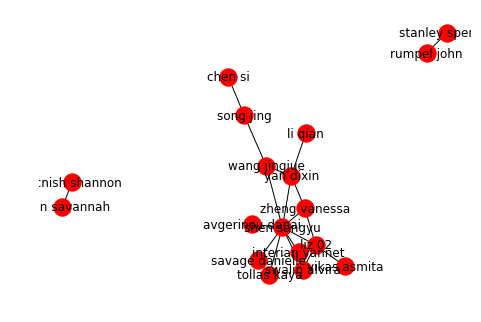

In [161]:
show_graph_with_labels(cosine_similarity_matrix)

We can see a network of who looks like who from this graph, which does not include all people. 

We can use below code to find, say who looks mostly similar to James.

In [185]:
np.argmax(cosine_similarity_matrix[86,]) # who is james most similar to

12

In [186]:
name_dict['86'], name_dict['12']

('wilson james', 'stanley spencer')

Professor James is most similar to Spencer